In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))


## Import local modules

In [2]:
import src.functions as F
from src.enumerations import *
from src.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from src.utils import paths_manager as pathsman
from src.stats.Statistical_analysis import extract_states, state_plot


## Constants

In [3]:
## Variable declaration for dataset
BUILDING = 1
START_TIME = "2015-01-01"
END_TIME = "2015-01-15"

FRIDGE_FREEZER = "fridge freezer"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]


## Subsect Dataset

In [4]:
## Dataset initialization
dataset = nilmtk.DataSet(pathsman.UKDALE_H5_PATH)
dataset.set_window(start=START_TIME, end=END_TIME)

In [5]:
def quantile_filter_2(sequence_length, data, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [6]:
power_elec = dataset.buildings[BUILDING].elec

In [7]:
print(f"Activation stats in the period [{START_TIME}, {END_TIME}]")
row = []

for app in applist:
    col = []
    app_name = app.upper()
    activations = power_elec[app].get_activations()
    total_num = len(activations)
    average_length = stat.mean(map(len, activations))
    max_length = max(map(len, activations))
    min_length = min(map(len, activations))
    col.append(total_num)
    col.append(average_length)
    col.append(max_length)
    col.append(min_length)
    row.append(col)

pd.DataFrame(row, columns=["No. of Activations", "Average Length", "Max Length", "Min Length"], index=applist)

Activation stats in the period [2015-01-01, 2015-01-15]


,No. of Activations,Average Length,Max Length,Min Length
fridge freezer,328,241.978659,1310,94
washer dryer,12,1021.666667,1204,893
kettle,57,27.315789,57,7
dish washer,4,1028.250000,1033,1022
microwave,118,18.932203,119,7


In [8]:
info = {
        FRIDGE_FREEZER : {
                "window" : 50,
                "min" : 0,
                "max" : 0,
                "on_power_threshold" : 10,
        },
        WASHER_DRYER : {               
                "window" : 50,
                "min" : 0,
                "max" : 0,
                "on_power_threshold" : 10,
        },
        KETTLE : {
                "window" : 50,
                "min" : 0,
                "max" : 0,
                "on_power_threshold" : 10,
        },
        DISHWASHER : {
                "window" : 10,
                "min" : 0,
                "max" : 0,
                "on_power_threshold" : 10,
        },
        MICROWAVE : {
                "window" : 50,
                "min" : 0,
                "max" : 0,
                "on_power_threshold" : 10,
        }
}

In [9]:
FULL_NUM_SAMPLES = 1200000

ACTIVATION_EXTENSION_MAPPING = {
    FRIDGE_FREEZER : {
        "mode" : "randomizer",
        "interval" : lambda : random.randint(70, 400),
    },
    WASHER_DRYER : {
        "mode" : "randomizer",
        "interval" : lambda : random.randint(200, 1700),
    },
    KETTLE : {
        "mode" : "randomizer",
        "interval" : lambda : random.randint(200, 1700),
    },
    DISHWASHER : {
        "mode" : "randomizer",
        "interval" : lambda : random.randint(200, 1700),
    },
    MICROWAVE : {
        "mode" : "randomizer",
        "interval" : lambda : random.randint(10, 700),
    },
}

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48428\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48428\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48428\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the mo

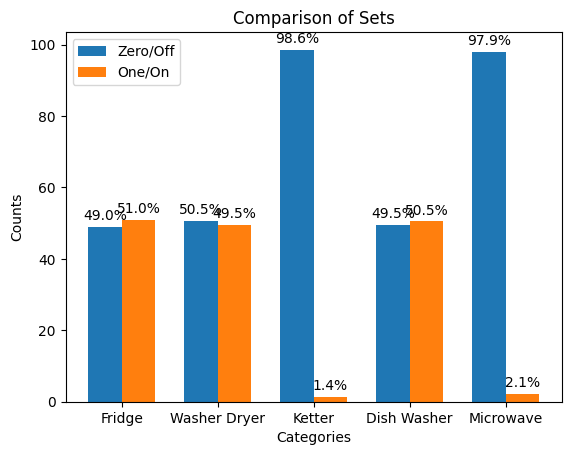

In [10]:
states = []
targets = []
unfiltered_power = []

normalizer = NormalizationHandler(mode="minmax", min_val=0, max_val=3300)

for app in applist:
        elec = power_elec[app]
        mode = ACTIVATION_EXTENSION_MAPPING[app]["mode"]
        interval = ACTIVATION_EXTENSION_MAPPING[app]["interval"]

        extended_activations = F.extend_activations(elec, mode=mode, num_full_samples=FULL_NUM_SAMPLES, interval=interval)
        unfiltered_power.append(extended_activations)
        filtered_data = quantile_filter_2(info[app]["window"], extended_activations, p=50)
        info[app]['min'] = 0.0
        info[app]['max'] = filtered_data.max()
        info[app]['on_power_threshold'] = elec.on_power_threshold()
        binarized_data = F.binarization(filtered_data, mode="threshold", threshold=power_elec[app].on_power_threshold())
        normalizer.select_mode(mode="minmax", min_val=info[app]['min'], max_val=info[app]['max'])
        normalized_data = normalizer.normalize(filtered_data)
        states.append(binarized_data)
        targets.append(normalized_data)

zero, one = extract_states(states)
state_plot(zero, one)

In [11]:
states = np.stack(states).T
targets = np.stack(targets).T

In [12]:
mains = np.sum(unfiltered_power, axis=0)

In [13]:
mains_denoise = quantile_filter_2(10, mains, 50)
mains = mains-np.percentile(mains, 1)
mains = np.where(mains < mains_denoise, mains_denoise, mains)
mains = quantile_filter_2(10, mains, 50)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48428\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


In [14]:
normalizer.select_mode(mode="minmax", min_val=mains_denoise.min(), max_val=mains_denoise.max())
norm_mains_denoise = normalizer.normalize(mains_denoise)

normalizer.select_mode(mode="minmax", min_val=mains.min(), max_val=mains.max())
norm_mains = normalizer.normalize(mains)

## Profile Handling

In [15]:
ProfileHandler.mkdir(pathsman.PROFILES_DIR, exist_ok=True)
prof = DatasetProfile(parent_dir=pathsman.PROFILES_DIR,
                      handler=NILMProjects.UNETNILM.value,
                      dataset_name="ukdale",
                      metadata=info,
                      mode="w")

ProfileHandler.write(norm_mains_denoise, norm_mains, targets, states, profile=prof, subdir="training")

DatasetProfile(parent_dir=WindowsPath('c:/Users/MTinaco/Dev/Solutions/cos-algo-nilm/src/utils/../../profiles'), handler='unetnilm', dataset_name='ukdale', metadata={'fridge freezer': {'window': 50, 'min': 0.0, 'max': 255.0, 'on_power_threshold': 50}, 'washer dryer': {'window': 50, 'min': 0.0, 'max': 2055.0, 'on_power_threshold': 20}, 'kettle': {'window': 50, 'min': 0.0, 'max': 2364.0, 'on_power_threshold': 10}, 'dish washer': {'window': 10, 'min': 0.0, 'max': 2411.0, 'on_power_threshold': 10}, 'microwave': {'window': 50, 'min': 0.0, 'max': 1564.0, 'on_power_threshold': 200}}, mode='w', full_path=WindowsPath('c:/Users/MTinaco/Dev/Solutions/cos-algo-nilm/src/utils/../../profiles/unetnilm_ukdale_20240315_134050'))